# YOLO Bounding Box -> solvePnP Test

This notebook tests the full pipeline:
1. Run YOLO prediction on one image
2. Convert predicted bounding box to image pixel corner points
3. Estimate object pose with `cv2.solvePnP`
4. Read object position in camera coordinates (`tvec`)

Set only `IMAGE_DIR` (and optionally `IMAGE_NAME`) in the config cell.

## Notes

- For accurate coordinates, you must use a calibrated camera matrix and distortion coefficients.
- The 3D object size (`OBJECT_WIDTH_M`, `OBJECT_HEIGHT_M`) should match the real target size.
- This notebook supports OBB models first, and falls back to axis-aligned boxes if needed.

## Step 1) 환경/설정

이 셀에서는 실험에 필요한 라이브러리를 로드하고, 아래 핵심 파라미터를 설정합니다.
- `IMAGE_DIR`, `IMAGE_NAME`: 테스트할 이미지 위치
- `MODEL_PATH`, `MODEL_TASK`, `CONF_THRES`: YOLO 추론 설정
- `CALIB_PATH`: 카메라 캘리브레이션 `.npz` 파일 경로
- `OBJECT_WIDTH_M`, `OBJECT_HEIGHT_M`: 실제 물체 크기(미터)
- `CAMERA_MATRIX`, `DIST_COEFFS`: `CALIB_PATH`에서 자동 로드되는 내부 파라미터

좌표 정확도는 카메라 캘리브레이션 값의 품질에 크게 영향받습니다.

In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

# ==============================
# Config: change these values
# ==============================
IMAGE_DIR = Path("/home/addinedu/yolo_ws/src/inference")
IMAGE_NAME = "capture_000020_jpg.rf.14969ef94a658965295eabf2bb93b1b4.jpg"

MODEL_PATH = Path("/home/addinedu/yolo_ws/src/inference/bolts-obb.pt")
CALIB_PATH = Path("/home/addinedu/yolo_ws/src/inference/camera_calib_upgraded_2026-01-12_16-17-24.npz")
MODEL_TASK = "obb"  # keep "obb" for your trained OBB model
CONF_THRES = 0.25

# Real object size in meters (update to your target dimensions)
OBJECT_WIDTH_M = 0.06
OBJECT_HEIGHT_M = 0.04

if not CALIB_PATH.exists():
    raise FileNotFoundError(f"Calibration file not found: {CALIB_PATH}")

calib = np.load(str(CALIB_PATH))
CAMERA_MATRIX = calib["camera_matrix"].astype(np.float64)
DIST_COEFFS = calib["dist_coeffs"].astype(np.float64)

if DIST_COEFFS.ndim == 1:
    DIST_COEFFS = DIST_COEFFS.reshape(-1, 1)
elif DIST_COEFFS.ndim == 2 and DIST_COEFFS.shape[0] == 1:
    DIST_COEFFS = DIST_COEFFS.reshape(-1, 1)

print("IMAGE_DIR:", IMAGE_DIR)
print("MODEL_PATH:", MODEL_PATH)
print("CALIB_PATH:", CALIB_PATH)
print("Loaded CAMERA_MATRIX shape:", CAMERA_MATRIX.shape)
print("Loaded DIST_COEFFS shape:", DIST_COEFFS.shape)

IMAGE_DIR: /home/addinedu/yolo_ws/src/inference
MODEL_PATH: /home/addinedu/yolo_ws/src/inference/bolts-obb.pt
CALIB_PATH: /home/addinedu/yolo_ws/src/inference/camera_calib_upgraded_2026-01-12_16-17-24.npz
Loaded CAMERA_MATRIX shape: (3, 3)
Loaded DIST_COEFFS shape: (5, 1)


## Step 2) 테스트 이미지 선택

이 셀은 입력 이미지를 결정합니다.
- `IMAGE_NAME`이 지정되면 해당 파일을 사용
- `None`이면 디렉토리 내 첫 번째 이미지(`jpg/jpeg/png/bmp`)를 자동 선택

이미지가 없으면 즉시 에러를 내서 원인을 빠르게 알 수 있게 했습니다.

In [2]:
def select_image_path(image_dir: Path, image_name: str | None = None) -> Path:
    if image_name:
        image_path = image_dir / image_name
        if not image_path.exists():
            raise FileNotFoundError(f"Image not found: {image_path}")
        return image_path

    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp"]
    candidates = []
    for ext in exts:
        candidates.extend(sorted(image_dir.glob(ext)))

    if not candidates:
        raise FileNotFoundError(f"No image found in: {image_dir}")

    return candidates[0]


image_path = select_image_path(IMAGE_DIR, IMAGE_NAME)
print("Selected image:", image_path)

Selected image: /home/addinedu/yolo_ws/src/inference/capture_000020_jpg.rf.14969ef94a658965295eabf2bb93b1b4.jpg


## Step 3) YOLO 추론 실행 및 1차 확인

이 셀은 모델을 로드하고 선택된 이미지에 대해 추론을 수행합니다.
- 왼쪽: 원본 이미지
- 오른쪽: YOLO가 예측한 박스가 그려진 이미지

여기서 검출이 제대로 되는지 먼저 확인한 뒤 다음 단계로 진행하면 디버깅이 쉬워집니다.

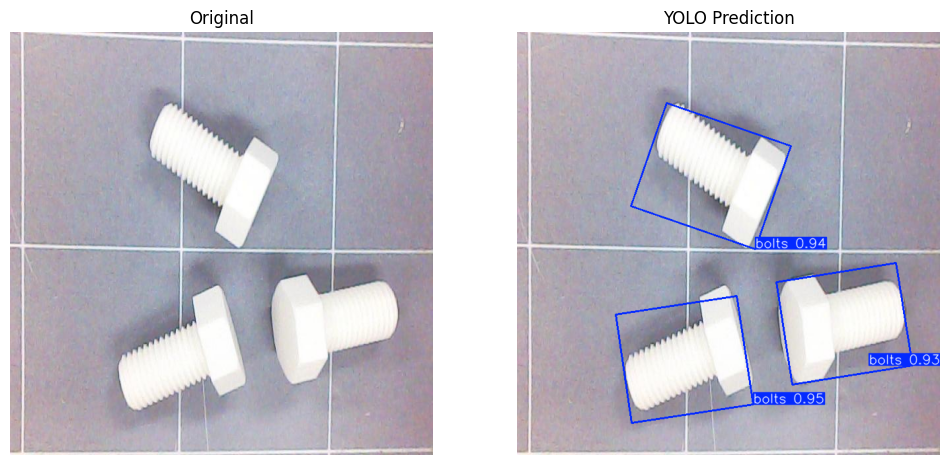

In [3]:
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")

model = YOLO(str(MODEL_PATH))
result = model.predict(
    source=str(image_path),
    conf=CONF_THRES,
    task=MODEL_TASK,
    verbose=False,
)[0]

orig_bgr = cv2.imread(str(image_path))
if orig_bgr is None:
    raise RuntimeError(f"Failed to read image: {image_path}")

pred_bgr = result.plot()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("YOLO Prediction")
plt.imshow(cv2.cvtColor(pred_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Step 4) 검출 박스를 solvePnP 입력 점(픽셀)로 변환

solvePnP는 2D-3D 점 대응이 필요하므로, **검출된 모든 물체**의 코너 4개를 정리합니다.
- OBB가 있으면 `xyxyxyxy`(4점)를 사용
- OBB가 없으면 일반 `xyxy` 박스에서 4점을 생성
- 점 순서는 `TL, TR, BR, BL`로 통일

이후 신뢰도 임계값을 통과한 모든 검출을 `detections` 리스트로 만들어 다음 단계에서 각각 solvePnP를 수행합니다.

In [4]:
def order_points_tl_tr_br_bl(pts: np.ndarray) -> np.ndarray:
    """Return points ordered as: top-left, top-right, bottom-right, bottom-left."""
    pts = np.asarray(pts, dtype=np.float64)
    if pts.shape != (4, 2):
        raise ValueError(f"Expected (4,2), got {pts.shape}")

    rect = np.zeros((4, 2), dtype=np.float64)
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def extract_detection_candidates(result_obj, conf_thres: float = 0.25):
    candidates = []
    names = getattr(result_obj, "names", {})

    # Priority: OBB detections
    if getattr(result_obj, "obb", None) is not None and len(result_obj.obb) > 0:
        obb_xyxyxyxy = result_obj.obb.xyxyxyxy.cpu().numpy()  # (N, 4, 2)
        if getattr(result_obj.obb, "conf", None) is not None:
            confs = result_obj.obb.conf.cpu().numpy()
        else:
            confs = np.ones((len(obb_xyxyxyxy),), dtype=np.float64)

        if getattr(result_obj.obb, "cls", None) is not None:
            clses = result_obj.obb.cls.cpu().numpy().astype(int)
        else:
            clses = np.full((len(obb_xyxyxyxy),), -1, dtype=int)

        for det_i, (pts, conf, cls_id) in enumerate(zip(obb_xyxyxyxy, confs, clses)):
            if float(conf) < conf_thres:
                continue
            ordered = order_points_tl_tr_br_bl(pts.reshape(4, 2))
            label = names.get(int(cls_id), str(int(cls_id))) if isinstance(names, dict) and cls_id >= 0 else "unknown"
            candidates.append(
                {
                    "det_idx": int(det_i),
                    "mode": "obb",
                    "conf": float(conf),
                    "cls_id": int(cls_id),
                    "label": label,
                    "img_points": ordered,
                }
            )

        return candidates

    # Fallback: axis-aligned boxes
    if getattr(result_obj, "boxes", None) is not None and len(result_obj.boxes) > 0:
        xyxy = result_obj.boxes.xyxy.cpu().numpy()  # (N,4)
        if getattr(result_obj.boxes, "conf", None) is not None:
            confs = result_obj.boxes.conf.cpu().numpy()
        else:
            confs = np.ones((len(xyxy),), dtype=np.float64)

        if getattr(result_obj.boxes, "cls", None) is not None:
            clses = result_obj.boxes.cls.cpu().numpy().astype(int)
        else:
            clses = np.full((len(xyxy),), -1, dtype=int)

        for det_i, (b, conf, cls_id) in enumerate(zip(xyxy, confs, clses)):
            if float(conf) < conf_thres:
                continue
            x1, y1, x2, y2 = b.astype(np.float64)
            pts = np.array(
                [[x1, y1], [x2, y1], [x2, y2], [x1, y2]],
                dtype=np.float64,
            )
            ordered = order_points_tl_tr_br_bl(pts)
            label = names.get(int(cls_id), str(int(cls_id))) if isinstance(names, dict) and cls_id >= 0 else "unknown"
            candidates.append(
                {
                    "det_idx": int(det_i),
                    "mode": "bbox",
                    "conf": float(conf),
                    "cls_id": int(cls_id),
                    "label": label,
                    "img_points": ordered,
                }
            )

    return candidates


detections = extract_detection_candidates(result, CONF_THRES)
if not detections:
    raise RuntimeError("No detection candidate found. Lower CONF_THRES or use a clearer image.")

detections = sorted(detections, key=lambda x: x["conf"], reverse=True)

print(f"Detected objects: {len(detections)}")
for i, det in enumerate(detections):
    pts = np.round(det["img_points"], 1)
    print(
        f"[{i}] mode={det['mode']} conf={det['conf']:.3f} class={det['label']} points={pts.tolist()}"
    )


Detected objects: 3
[0] mode=obb conf=0.947 class=bolts points=[[149.0, 427.4], [332.2, 399.5], [357.1, 563.2], [173.9, 591.1]]
[1] mode=obb conf=0.942 class=bolts points=[[226.9, 107.6], [415.0, 172.8], [360.8, 328.9], [172.7, 263.6]]
[2] mode=obb conf=0.929 class=bolts points=[[392.1, 378.4], [573.5, 349.2], [598.4, 504.2], [417.0, 533.4]]


## Step 5) solvePnP로 카메라 좌표계 위치 계산

이 셀은 **각 물체별로** 3D 물체 점(`object_points`)과 2D 이미지 점(`img_points`)을 매칭해 자세를 추정합니다.
- 출력 `rvec`: 회전(로드리게스 벡터)
- 출력 `tvec`: 평행이동 벡터

각 물체의 `tvec = [X, Y, Z]`가 카메라 기준 좌표(단위: 미터)이며, 결과는 `poses` 리스트에 저장됩니다.

In [5]:
# 3D object corner points in object coordinate frame (z=0 plane)
w = float(OBJECT_WIDTH_M)
h = float(OBJECT_HEIGHT_M)
object_points = np.array(
    [
        [-w / 2, -h / 2, 0.0],  # top-left
        [w / 2, -h / 2, 0.0],   # top-right
        [w / 2, h / 2, 0.0],    # bottom-right
        [-w / 2, h / 2, 0.0],   # bottom-left
    ],
    dtype=np.float64,
)

poses = []
for i, det in enumerate(detections):
    image_points = det["img_points"].astype(np.float64)

    ok, rvec, tvec = cv2.solvePnP(
        objectPoints=object_points,
        imagePoints=image_points,
        cameraMatrix=CAMERA_MATRIX,
        distCoeffs=DIST_COEFFS,
        flags=cv2.SOLVEPNP_ITERATIVE,
    )

    if not ok:
        print(f"[WARN] solvePnP failed for detection #{i}")
        continue

    R, _ = cv2.Rodrigues(rvec)
    tx, ty, tz = tvec.reshape(3)
    distance = float(np.linalg.norm(tvec))

    poses.append(
        {
            **det,
            "image_points": image_points,
            "rvec": rvec,
            "tvec": tvec,
            "R": R,
            "xyz": (float(tx), float(ty), float(tz)),
            "distance": distance,
        }
    )

if not poses:
    raise RuntimeError("solvePnP failed for all detected objects")

print(f"solvePnP success: {len(poses)} / {len(detections)}")
for i, pose in enumerate(poses):
    tx, ty, tz = pose["xyz"]
    print(
        f"[{i}] class={pose['label']} conf={pose['conf']:.3f} -> X={tx:.4f}m Y={ty:.4f}m Z={tz:.4f}m dist={pose['distance']:.4f}m"
    )


solvePnP success: 3 / 3
[0] class=bolts conf=0.947 -> X=-0.0030m Y=0.0473m Z=0.2288m dist=0.2336m
[1] class=bolts conf=0.942 -> X=0.0068m Y=-0.0198m Z=0.2356m dist=0.2365m
[2] class=bolts conf=0.929 -> X=0.0586m Y=0.0358m Z=0.2366m dist=0.2464m


## Step 6) 결과 시각화

이 셀은 **모든 물체**의 추정 결과를 한 번에 표시합니다.
- 각 물체의 4개 코너 점/윤곽선 표시
- 각 물체별 3D 좌표축(X/Y/Z) 투영
- 각 물체별 `X, Y, Z`와 confidence 정보 오버레이

여러 객체가 동시에 정상적으로 좌표 계산되는지 시각적으로 검증할 수 있습니다.

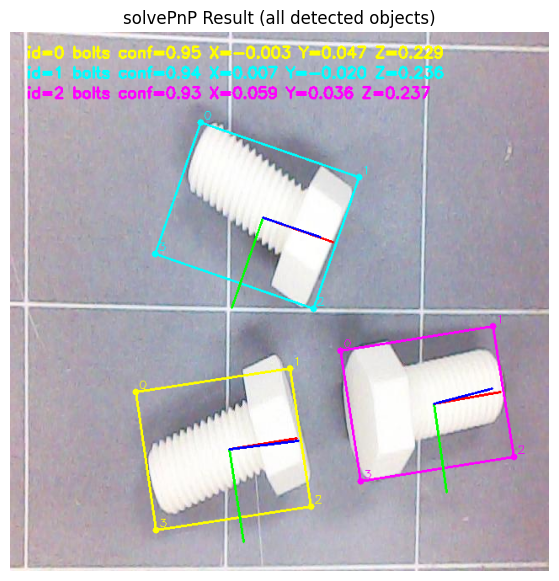

In [6]:
vis = orig_bgr.copy()

axis_len = min(OBJECT_WIDTH_M, OBJECT_HEIGHT_M) * 0.7
axis_3d = np.array(
    [
        [0.0, 0.0, 0.0],
        [axis_len, 0.0, 0.0],
        [0.0, axis_len, 0.0],
        [0.0, 0.0, -axis_len],
    ],
    dtype=np.float64,
)

palette = [
    (0, 255, 255),
    (255, 255, 0),
    (255, 0, 255),
    (0, 255, 0),
    (0, 128, 255),
    (255, 128, 0),
]

for i, pose in enumerate(poses):
    color = palette[i % len(palette)]
    poly = pose["image_points"].astype(np.int32)

    # Draw quadrilateral corners
    cv2.polylines(vis, [poly], isClosed=True, color=color, thickness=2)
    for j, p in enumerate(poly):
        cv2.circle(vis, tuple(p), 4, color, -1)
        cv2.putText(
            vis,
            str(j),
            tuple(p + np.array([4, -4])),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.45,
            color,
            1,
        )

    # Draw local 3D axes
    proj, _ = cv2.projectPoints(axis_3d, pose["rvec"], pose["tvec"], CAMERA_MATRIX, DIST_COEFFS)
    proj = proj.reshape(-1, 2).astype(np.int32)
    p0, px, py, pz = proj

    cv2.line(vis, tuple(p0), tuple(px), (0, 0, 255), 2)   # X: red
    cv2.line(vis, tuple(p0), tuple(py), (0, 255, 0), 2)   # Y: green
    cv2.line(vis, tuple(p0), tuple(pz), (255, 0, 0), 2)   # Z: blue

    tx, ty, tz = pose["xyz"]
    caption = f"id={i} {pose['label']} conf={pose['conf']:.2f} X={tx:.3f} Y={ty:.3f} Z={tz:.3f}"
    cv2.putText(
        vis,
        caption,
        (20, 30 + i * 24),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        color,
        2,
    )

plt.figure(figsize=(12, 7))
plt.title("solvePnP Result (all detected objects)")
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


## Quick checklist if result looks wrong

- Replace `CAMERA_MATRIX`, `DIST_COEFFS` with calibrated camera values
- Set correct real object size (`OBJECT_WIDTH_M`, `OBJECT_HEIGHT_M`)
- Ensure YOLO corner order is consistent (this notebook re-orders points)
- Test with clearer image and front-facing object first